### Interpretability of Acustic Emission Sound Data classification using a CNN model and Grad-CAM

In [2]:
# Imports
import numpy as np
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import activations
from itertools import islice
from sklearn.preprocessing import normalize
sns.set()

length = 277

In [4]:
from pandas import read_csv
from numpy import set_printoptions
from sklearn import datasets, linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
import numpy as np
import pathlib

# Using GPU
import os
import scipy.io as scpy
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


### Extract task-specific data and labels

In [204]:
from pandas import read_csv
from numpy import set_printoptions
from sklearn import datasets, linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import random
# Using GPU
import os
import scipy.io as scpy

data = scpy.loadmat("all-data.mat")
# Extracting x_train from the mat file dictionary.
x_data = data["XTrain"]
# Extracting y_train from the mat file dictionary.
y_data = data["y_train"]
# Converting x_train and y_train to a numpy array.
x_data = np.array(x_data,dtype='float32')
y_data = np.array(y_data,dtype='float32')-1
x_temp_data=data['XTest']
y_temp_data=data['y_test']
x_temp_data=np.array(x_temp_data,dtype='float32')
y_temp_data=np.array(y_temp_data,dtype='float32')-1
x_data=np.concatenate((x_data,x_temp_data),axis=0)
y_data=np.concatenate((y_data,y_temp_data),axis=0)

# Verifying the shapes.
print(x_data.shape)
print(y_data.shape)

SEED = 99
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# split into train test sets
x_train, x_val_to_use, y_train, y_val_to_use = train_test_split(x_data, y_data, test_size=0.3, random_state=SEED)

x_val=x_val_to_use[:2500]
y_val=y_val_to_use[:2500]
x_test = x_val_to_use[2500:]
y_test = y_val_to_use[2500:]
print(f" {len(x_train), len(x_val), len(x_test)}")
print(f" {len(y_train), len(y_val), len(y_test)}")
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
BATCH_SIZE = 64
# SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


(16650, 1000)
(16650, 1)
 (11655, 2500, 2495)
 (11655, 2500, 2495)


In [196]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)


(13320, 1000)
(13320, 1)
(1500, 1000)
(1500, 1)
(1830, 1000)
(1830, 1)


### Build the CNN architecture, train, and predict on the test set

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_39 (Reshape)        (None, 1000, 1, 1)        0         
                                                                 
 last_conv_layer (Conv2D)    (None, 1000, 1, 2)        34        
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 250, 1, 2)        0         
 g2D)                                                            
                                                                 
 flatten_36 (Flatten)        (None, 500)               0         
                                                                 
 dense_91 (Dense)            (None, 4)                 2004      
                                                                 
 dense_92 (Dense)            (None, 3)                 15        
                                                     

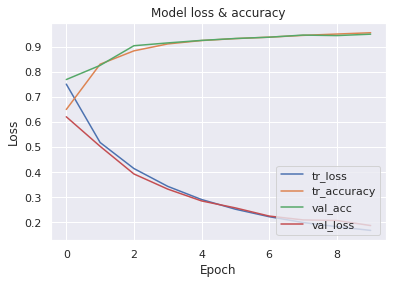

In [213]:
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()

verbose, epoch, batch_size = 1, 10, 64
activationFunction='relu'

def getModel(): 
    cnnmodel = Sequential()
    cnnmodel.add(tf.keras.layers.Reshape((x_train.shape[1],1,1), input_shape=(1000,)))
    cnnmodel.add(tf.keras.layers.Conv2D(filters=2, kernel_size=4,padding='same', activation='relu',name='last_conv_layer'))
    cnnmodel.add(tf.keras.layers.MaxPooling2D(pool_size=4,padding='same'))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(4, activation='relu'))
    cnnmodel.add(Dense(3, activation='softmax'))
    cnnmodel.summary()
    cnnmodel.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), 
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    return cnnmodel

cnnmodel = getModel()
cnnhistory= cnnmodel.fit(x_train, y_train, epochs=epoch, verbose=verbose, validation_data=(x_val, y_val), batch_size = batch_size)

# Plotting accuracy and loss
import matplotlib.pyplot as plt
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.plot(cnnhistory.history['val_loss'])


plt.title('Model loss & accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tr_loss', 'tr_accuracy', 'val_acc', 'val_loss'], loc='lower right')
# accuracy!
print("Training results")
print(f"Training Accuracy: {cnnhistory.history['accuracy'][-1]}")
print(f"Training Loss: {cnnhistory.history['loss'][-1]}")

# evaluating model
print("Evaluation results")
print(f"Validation Accuracy: {cnnhistory.history['val_accuracy'][-1]}")
print(f"Validation Loss: {cnnhistory.history['val_loss'][-1]}")


plt.show()

In [206]:
# # Save the model so we can visualize it with Netron (https://github.com/lutzroeder/netron):
tf.keras.models.save_model(cnnmodel, 'cnnmodel_gradcamcam_ecg_paper.h5')

### Choose a class to get the Grad-CAM values for

In [248]:
# Get all the data that corresponds to one single class (class 8 / 'I'):
class_num = 0
class_indices = np.where(y_test == class_num)[0]
class_data = x_test[class_indices]
class_output = y_test[class_indices]
class_ann = 'T'   # 'S'for one and 'M' for 2
cnnpredictions = cnnmodel.predict(class_data, verbose=1)
print(class_data.shape)
print(cnnpredictions.shape)
print(class_output.shape)

26/26 [==============================] - 0s 820us/step
(811, 1000)
(811, 3)
(811, 1)


### Create a performance metrics function

In [249]:
def showResults(test, pred, model_name):
    accuracy = accuracy_score(test, pred)
    precision= precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average = 'macro')
    f1score= f1_score(test, pred, average='macro') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score : {}".format(f1score))
    cm=confusion_matrix(test, pred, labels=[0,1,2])
    return (model_name, round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score,3), cm)

In [137]:
print(y_test.shape)

(1650, 1)


### Call the performance metrics function per class

Accuracy  : 0.9531442663378545
Precision : 0.3333333333333333
Recall : 0.3177147554459515
f1score : 0.32533670033670037


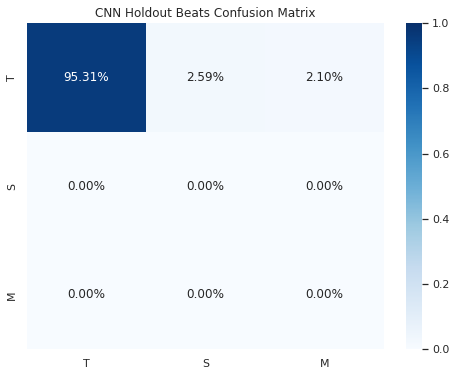

In [250]:
cnn_predict=np.argmax(cnnpredictions,axis=1)
cnn_actual_value=np.reshape(np.array(class_output,dtype='int32'),(len(class_data),))
cnn_results = showResults(cnn_actual_value, cnn_predict,'CNN')

# Plot confusion matrix:
categories=['T','S','M']
fig = plt.figure(figsize=(8,6))
CNN_cf_m = cnn_results[5].astype('float')/ cnn_results[5].sum(axis=1)[:,np.newaxis]
sns.heatmap(np.nan_to_num(CNN_cf_m),annot=True,fmt='.2%',xticklabels=categories,yticklabels=categories,vmin=0,vmax=1,cmap='Blues')
plt.title('CNN Holdout Beats Confusion Matrix')
plt.show()
# fig.savefig('cm.jpg', dpi = 400)

In [251]:
print(cnn_predict.shape)
print(cnn_actual_value.shape)
my_acc = (cnn_predict==cnn_actual_value).sum()/len(cnn_actual_value)
print(my_acc)


(811,)
(811,)
0.9531442663378545


### Compute Grad-CAM values for the class chosen above

In [252]:
# Turn off the final Softmax activation function:
cnnmodel.layers[-1].activation = None

In [253]:
# Create a model that maps the input heartbeat to the feature maps of the last convolutional layer 
# and the output (before applying Softmax):
grad_model = tf.keras.models.Model([cnnmodel.inputs], [cnnmodel.get_layer('last_conv_layer').output, cnnmodel.output])

# Step 1: Compute the gradient of the output with respect to the feature maps:
with tf.GradientTape() as tape:
    last_conv_layer_features, y_predictions = grad_model(class_data)
grads = tape.gradient(y_predictions, last_conv_layer_features)

# Step 2: Calculate alpha values by averaging the gradients:
alpha_values = tf.reduce_mean(grads, axis = 1)

# Step 3: Use the alpha values as the weight of the corresponding feature map: 
gradcam = tf.linalg.matmul(last_conv_layer_features, alpha_values[..., tf.newaxis])

In [254]:
# Normalize the grad-CAM values for visualization:
gradcam = gradcam.numpy()
gradcam = np.abs(gradcam)
gradcam_norm = (gradcam - np.min(gradcam, axis = 1, keepdims = True)) / (np.max(gradcam, axis = 1, keepdims = True) - 
                                                        np.min(gradcam, axis = 1, keepdims = True))
y_predictions = tf.nn.softmax(y_predictions)
y_predictions = y_predictions.numpy()

### Visualize Grad-CAM results with saliency maps for the correctly classified sounds

773


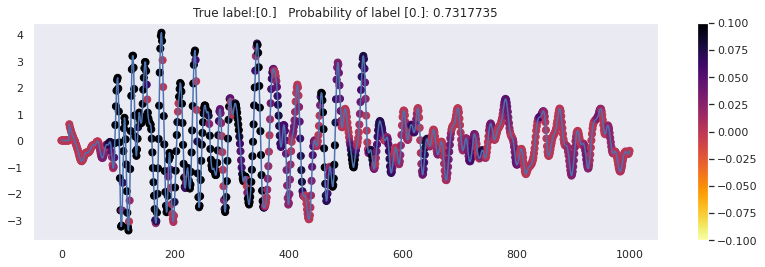

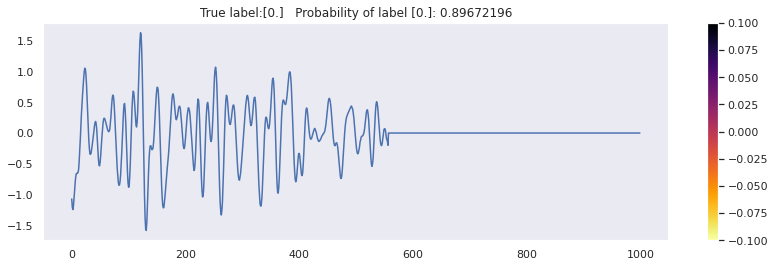

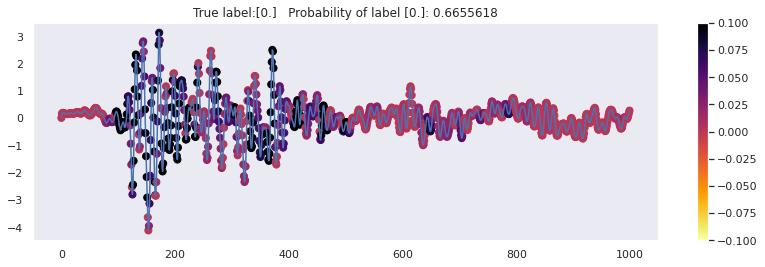

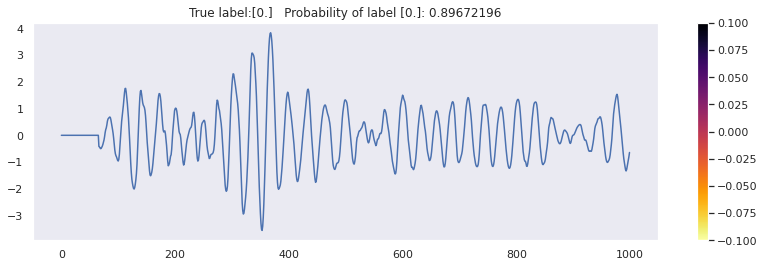

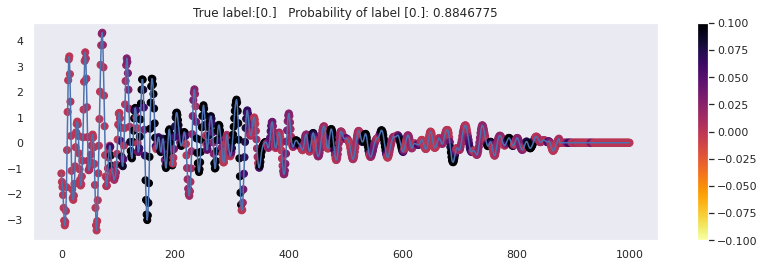

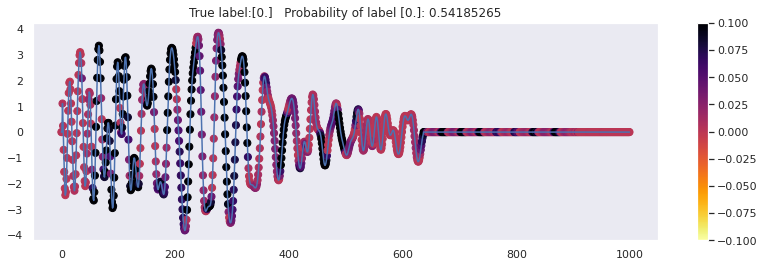

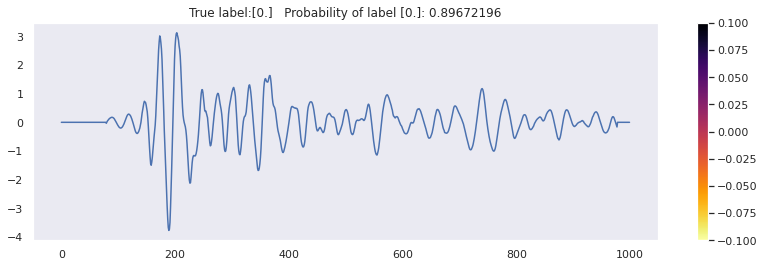

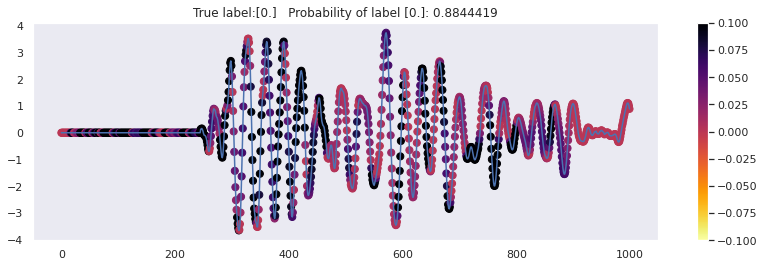

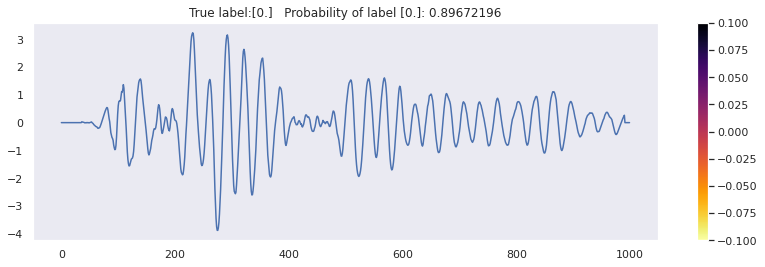

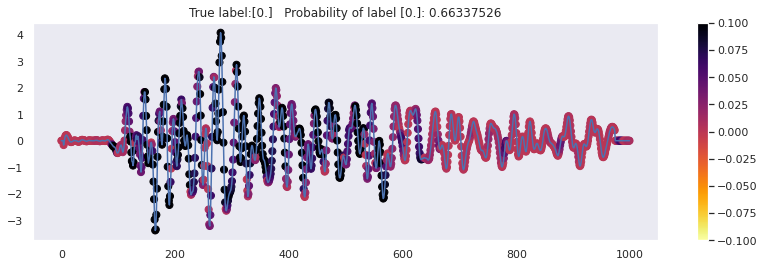

In [264]:
import warnings
warnings.filterwarnings('ignore')
# Get the corectly classified data:
correct_cnn = np.where(cnn_predict == cnn_actual_value)
correct_cnn = correct_cnn[0].tolist()
print(len(correct_cnn))
# Plot a few examples of heatmaps:

for i in correct_cnn[10:20]:
    plt.figure(figsize=(14, 4))
    plt.grid(False)
    plt.plot(x_test[i].squeeze())
    plt.scatter(np.arange(len(class_data[i])), x_test[i].squeeze(), cmap='inferno_r', c=gradcam_norm[i,:].squeeze(), s=50)
    plt.title('True label:' + str(class_output[i]) + '   Probability of label ' + str(class_output[i]) + ': ' + str(y_predictions[i, int(class_output[i])]))
    clim= np.ravel(gradcam_norm)
    plt.clim(min(clim),max(clim))
    plt.colorbar()
    plt.show

### Visualize Grad-CAM results with saliency maps for the sounds that were not correctly classified

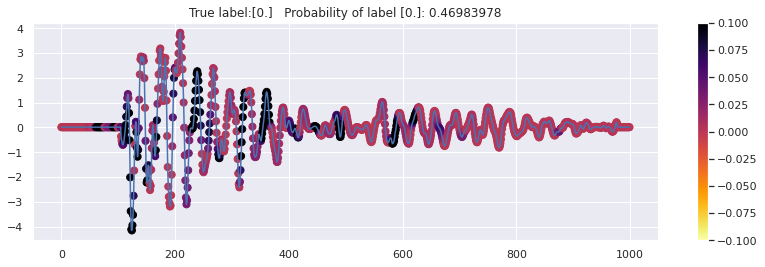

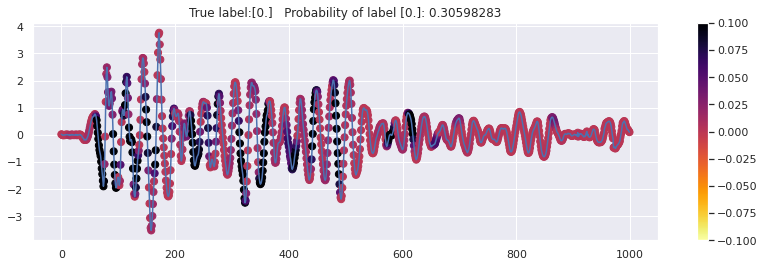

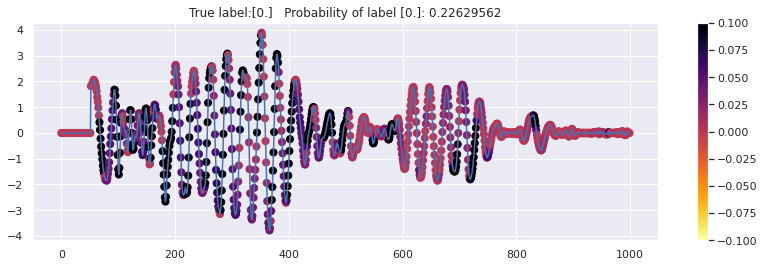

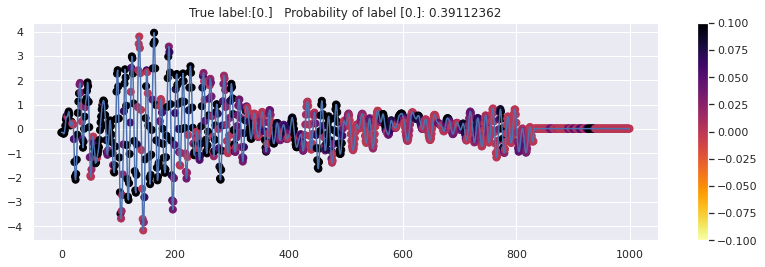

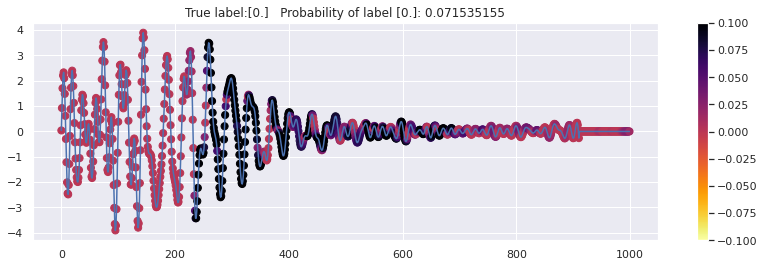

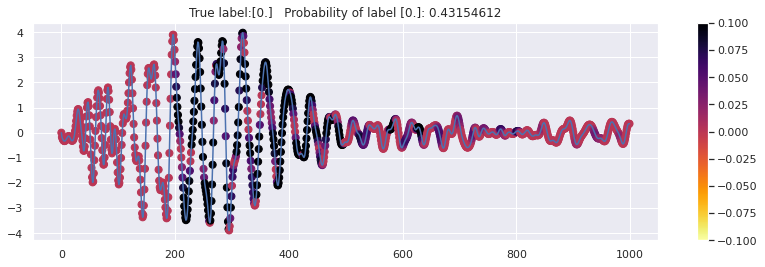

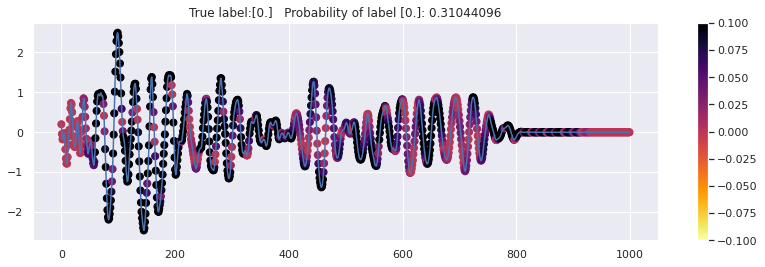

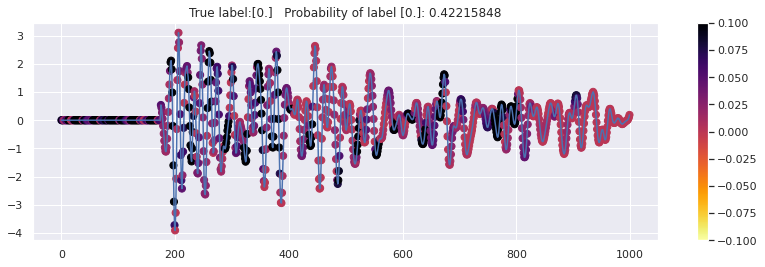

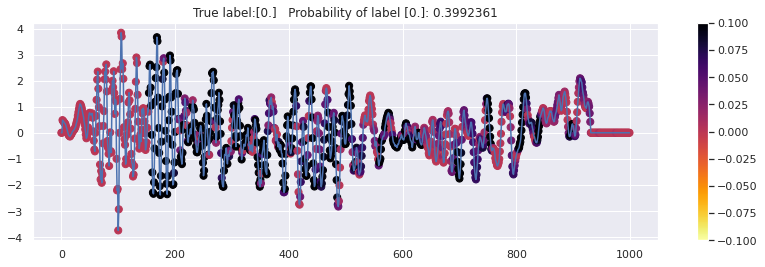

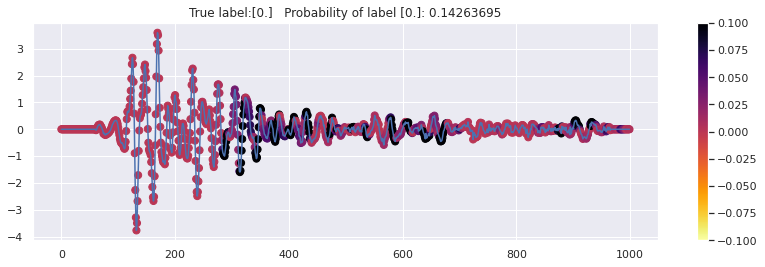

In [256]:
# Get the misclassified data:
misclass_cnn = np.where(cnn_predict!=cnn_actual_value)
misclass_cnn = misclass_cnn[0].tolist()

# Plot a few examples of heatmaps:
for i in misclass_cnn[10:20]:
    plt.figure(figsize=(14, 4))
    plt.plot(x_test[i].squeeze())
    plt.scatter(np.arange(len(class_data[i])), x_test[i].squeeze(), cmap='inferno_r', c=gradcam_norm[i,:].squeeze(), s=50)
    plt.title('True label:' + str(class_output[i]) + '   Probability of label ' + str(class_output[i]) + ': ' + str(y_predictions[i, int(class_output[i])]))
    clim= np.ravel(gradcam_norm)
    plt.clim(min(clim),max(clim))
    plt.colorbar()
    plt.show

### Divide the sounds into 3 segments and compute the Grad-CAM values per segment

In [285]:
# Means of slice function:
def means_of_slices(iterable, slice_size):
    iterator = iter(iterable)
    while True:
        slice = list(islice(iterator, slice_size))
        if slice:
            yield np.sum(slice)/len(slice)
        else:
            return

# Divide the result into slices:
cam_per_segment = []
for i in range(class_data.shape[0]):
    means = list(means_of_slices(gradcam_norm[i], 25))
    cam_per_segment.append(means)
cam_per_segment = np.array(cam_per_segment)
print(cam_per_segment.shape)

# Repeat the values 25 times for visualization purposes:
cam_per_segment_repeat = []
for i in cam_per_segment:
    cam_per_segment_repeat.append(np.repeat(i,25))
cam_per_segment_repeat = np.array(cam_per_segment_repeat)
print(cam_per_segment_repeat.shape)

(811, 40)
(811, 1000)


### Plot the average Grad-CAM values per segment on a sample sound

In [283]:
# Normalize correct and incorrect predictions:
ae_correct_norm = normalize(cam_per_segment_repeat[correct_cnn[:1000]])
ae_incorrect_norm = normalize(cam_per_segment_repeat[misclass_cnn[:10]])

# Normalize ECG heartbeat example:
ae_norml = normalize(class_data)

# Take means of all correct and incorrect segments:
mean_correct = ae_correct_norm.mean(axis=0)
mean_incorrect = ae_incorrect_norm.mean(axis=0)

# Visualize:
plt.figure(figsize=(12,4))
plt.plot(ae_norml[1],color='b',label='Sample Acustic Signal')
plt.plot(np.abs(mean_incorrect), color='r', label='Misclass')
plt.plot(np.abs(mean_correct), color='g', label='Correct')
plt.title('Average Grad-CAM values over '+'Class: ' + 'T' +', Number: ' + str(3))
plt.legend()
# plt.savefig('cnn_gradcam_' + 'T' + '.jpg', bbox_inches='tight',dpi=400)
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [282]:
# Normalize correct and incorrect predictions:
ae_correct_norm = normalize(cam_per_segment_repeat[correct_cnn[:1000]])
ae_incorrect_norm = normalize(cam_per_segment_repeat[misclass_cnn[:10]])

# Normalize ECG heartbeat example:
ae_norml = normalize(x_test)

# Take means of all correct and incorrect segments:
mean_correct = ae_correct_norm.mean(axis=0)
mean_incorrect = ae_incorrect_norm.mean(axis=0)

# Visualize:
plt.figure(figsize=(12,4))
plt.plot(ae_norml[3],color='b',label='Sample ECG Beat')
plt.plot(np.abs(mean_incorrect), color='r', label='Misclass')
plt.plot(np.abs(mean_correct), color='g', label='Correct')
plt.title('Average Grad-CAM values over '+'Class: ' + 'T' +', Number: ' + str(3))
plt.legend()
# plt.savefig('cnn_gradcam_' + 'T' + '.jpg', bbox_inches='tight',dpi=400)
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').